In [1]:
%pip install diffusers transformers accelerate peft bitsandbytes datasets scipy

  Using cached scipy-1.16.3-cp313-cp313-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (62 kB)
  Using cached aiohttp-3.13.2-cp313-cp313-manylinux2014_x86_64.manylinux_2_17_x86_64.manylinux_2_28_x86_64.whl.metadata (8.1 kB)
  Using cached aiohappyeyeballs-2.6.1-py3-none-any.whl.metadata (5.9 kB)
  Using cached aiosignal-1.4.0-py3-none-any.whl.metadata (3.7 kB)
  Using cached frozenlist-1.8.0-cp313-cp313-manylinux1_x86_64.manylinux_2_28_x86_64.manylinux_2_5_x86_64.whl.metadata (20 kB)
  Using cached multidict-6.7.0-cp313-cp313-manylinux2014_x86_64.manylinux_2_17_x86_64.manylinux_2_28_x86_64.whl.metadata (5.3 kB)
  Using cached propcache-0.4.1-cp313-cp313-manylinux2014_x86_64.manylinux_2_17_x86_64.manylinux_2_28_x86_64.whl.metadata (13 kB)
  Using cached yarl-1.22.0-cp313-cp313-manylinux2014_x86_64.manylinux_2_17_x86_64.manylinux_2_28_x86_64.whl.metadata (75 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 26.7 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [2]:
import torch
import time
from diffusers import DiffusionPipeline

# --- 1. Helper for nice formatting ---
def bytes_to_gb(bytes_val):
    return f"{bytes_val / 1024**3:.2f} GB"

# --- 2. Load Model (Warm-up) ---
print("⏳ Loading SDXL Model... (Tracking load time)")
t_start_load = time.time()

pipe = DiffusionPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0", 
    torch_dtype=torch.float16, 
    use_safetensors=True, 
    variant="fp16"
)

# Move to GPU
if torch.cuda.is_available():
    pipe.to("cuda")
    # Reset peak memory stats so we only measure inference later
    torch.cuda.reset_peak_memory_stats()
    
t_end_load = time.time()
print(f"✅ Model Loaded in {t_end_load - t_start_load:.2f} seconds")


# --- 3. Define Performance Generation Function ---
def generate_with_stats(prompt, steps=40):
    print(f"\n🎨 Generating: '{prompt}'")
    print(f"⚙️  Steps: {steps}")
    
    # Reset stats before run
    torch.cuda.reset_peak_memory_stats()
    torch.cuda.empty_cache()
    start_vram = torch.cuda.memory_allocated()
    
    # Start Timer
    t0 = time.time()
    
    # Run Generation
    image = pipe(
        prompt=prompt, 
        num_inference_steps=steps
    ).images[0]
    
    t1 = time.time()
    
    # Collect Stats
    total_time = t1 - t0
    peak_vram = torch.cuda.max_memory_allocated()
    it_per_sec = steps / total_time
    
    # Print Report
    print("-" * 40)
    print(f"🚀 PERFORMANCE REPORT (Nvidia 4070 Ti)")
    print("-" * 40)
    print(f"⏱️  Total Time:       {total_time:.2f} s")
    print(f"⚡ Speed:            {it_per_sec:.2f} it/s")
    print(f"💾 VRAM Before:      {bytes_to_gb(start_vram)}")
    print(f"📈 VRAM Peak:        {bytes_to_gb(peak_vram)}")
    print(f"📉 VRAM Diff (Used): {bytes_to_gb(peak_vram - start_vram)}")
    print("-" * 40)
    
    return image


⏳ Loading SDXL Model... (Tracking load time)


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

✅ Model Loaded in 3.71 seconds



🎨 Generating: 'Realistic post-apocalyptic abandoned arcade, dusty rusted arcade cabinets, cracked screens, broken joysticks, vines and moss reclaiming machines, plants through cracked tiles, sunlight through broken windows, floating dust, debris and scattered tokens, muted colors, cinematic lighting, wide-angle, ultra-detailed, melancholic atmosphere'
⚙️  Steps: 30


  0%|          | 0/30 [00:00<?, ?it/s]

----------------------------------------
🚀 PERFORMANCE REPORT (Nvidia 4070 Ti)
----------------------------------------
⏱️  Total Time:       7.26 s
⚡ Speed:            4.13 it/s
💾 VRAM Before:      6.57 GB
📈 VRAM Peak:        10.48 GB
📉 VRAM Diff (Used): 3.91 GB
----------------------------------------


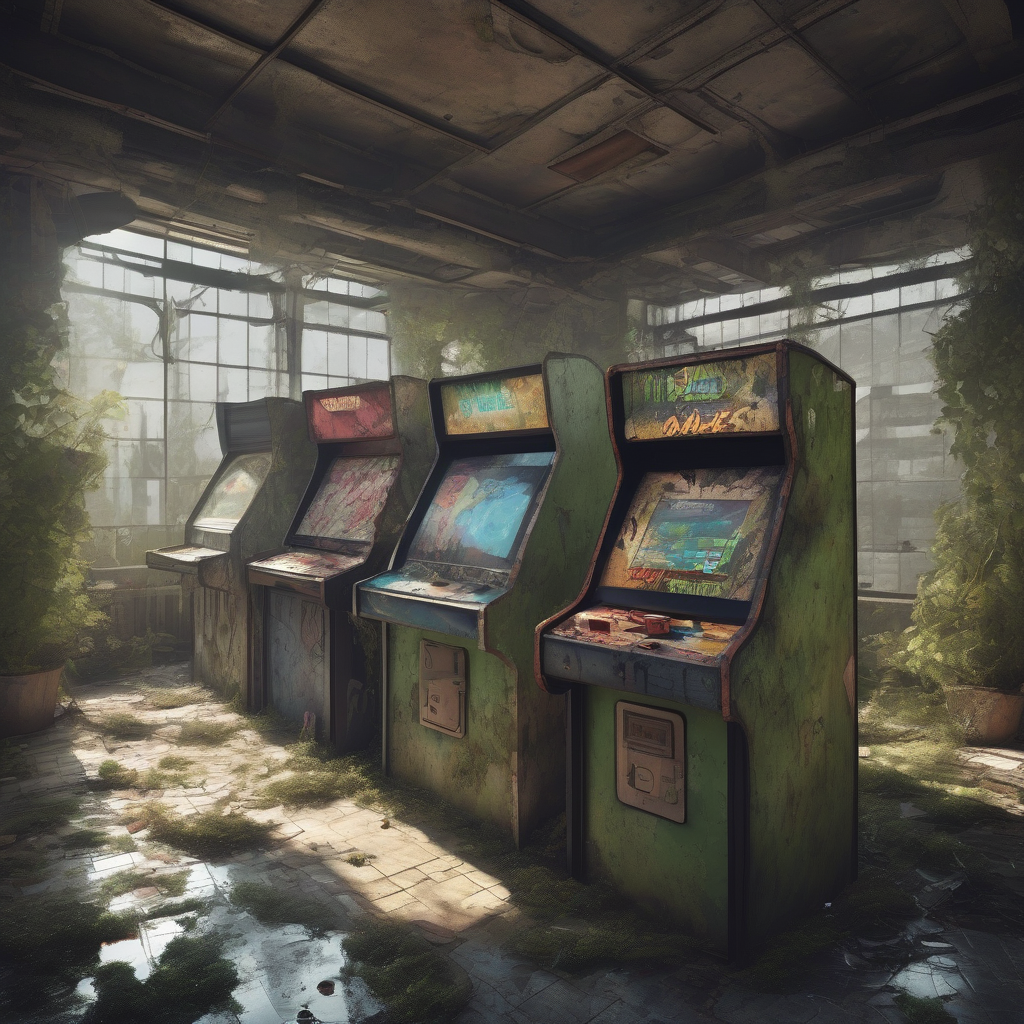

In [6]:

prompt = "Realistic post-apocalyptic abandoned arcade, dusty rusted arcade cabinets, cracked screens, broken joysticks, vines and moss reclaiming machines, plants through cracked tiles, sunlight through broken windows, floating dust, debris and scattered tokens, muted colors, cinematic lighting, wide-angle, ultra-detailed, melancholic atmosphere"

image = generate_with_stats(prompt, steps=30)

# Display
display(image)